# Part 1 : Selecting Scenario

#### You and a group of friends are considering purchasing a property in Chicago that you can use as an investment. You have heard from other people that they have made a lot of money by renting out either a room or an entire unit (apartment or house). Your friends ask you to analyze data so that they can understand how much you would charge per night based on the type of dwelling you were to purchase. 


# Part 2 : Splitting and Storing data

I have choose to work with Airbnb data from chicago. So Firstly lets get the dataset from the provided source.

In [66]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


I have used the kagglehub package to download the dataset from kaggle. And then I read the data from the downloaded file into a pandas dataframe.

In [67]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jinbonnie/chicago-airbnb-open-data")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\chandan\.cache\kagglehub\datasets\jinbonnie\chicago-airbnb-open-data\versions\2


I have downloaded the dataset and read it into a pandas dataframe.

In [68]:
initial_data = pd.read_csv('listings.csv')

I have loaded the dataset and printed its basic information. 

In [69]:
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6397 entries, 0 to 6396
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6397 non-null   int64  
 1   name                            6397 non-null   object 
 2   host_id                         6397 non-null   int64  
 3   host_name                       6397 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   6397 non-null   object 
 6   latitude                        6397 non-null   float64
 7   longitude                       6397 non-null   float64
 8   room_type                       6397 non-null   object 
 9   price                           6397 non-null   int64  
 10  minimum_nights                  6397 non-null   int64  
 11  number_of_reviews               6397 non-null   int64  
 12  last_review                     52

There are 48,895 rows and 16 columns in the dataset. There are some missing values in some columns. Those columns are : neighbourhood_group, last_review, reviews_per_month. I will check some data with head function to see the data.

In [70]:
initial_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168


First thing first, lets split the 100 data from dataset for validation later and save it. the validation set will be used later and act as live data later on. The remaining data will be used for training our model.

In [71]:
validation_set = initial_data.sample(n=100, random_state=42)  

# Get the remaining data for training
training_set = initial_data.drop(validation_set.index)

# Save the datasets if needed
validation_set.to_csv("validation_set.csv", index=False)
training_set.to_csv("training_set.csv", index=False)

Lets reload the data that we save as training set by spliting 100 validation dataset.

In [72]:
df = pd.read_csv('training_set.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168


Lets, load this dataset in raw schema of our database

In [73]:
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'postgres' # this is the password established during installation
port = r'5432' # default port estabalished during install
 



In [74]:
engine = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [75]:
schema = r'raw'
table = r'chicago_airbnb_raw'

I have created a raw schema in my database and then stored the data from our pandas dataframe into this schema as table chicago_airbnb_raw.

In [76]:
df.to_sql(table, con=engine, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

6297

Here is the screenshot of the raw schema stored in database

![raw_schema](raw_schema.png)

# Part 3 –Data Definition and Analytical Question

First, let's check the data types of our columns. There are several columns with mixed data types. We need to convert some of them to appropriate data types for further analysis. Columns contained integers, floats, and objects.

In [77]:
print(df.dtypes)

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object



### **Data Definition**

| **Field Name**                     | **Description**                                           | **Data Type (Pandas dtype)**   | **Conceptual Type**          |
|-------------------------------------|-----------------------------------------------------------|-------------------------------|-----------------------------|
| `id`                                | Unique identifier for the listing                         | `int64`                        | **Discrete (Integer)**      |
| `name`                              | Name of the Airbnb listing                                | `object`                       | **Nominal (String/Text)**   |
| `host_id`                           | Unique identifier for the host                            | `int64`                        | **Discrete (Integer)**      |
| `host_name`                         | Name of the host                                          | `object`                       | **Nominal (String/Text)**   |
| `neighbourhood_group`               | Larger geographical area (if applicable)                 | `float64`                      | **Nominal (Categorical/Float)** |
| `neighbourhood`                     | Specific neighborhood                                     | `object`                       | **Nominal (Categorical/String)** |
| `latitude`                          | Geographical latitude of the listing                     | `float64`                      | **Continuous (Float)**      |
| `longitude`                         | Geographical longitude of the listing                    | `float64`                      | **Continuous (Float)**      |
| `room_type`                         | Type of room (Entire home, Private room, Shared room)    | `object`                       | **Nominal (Categorical/String)** |
| `price`                             | Price per night in USD                                   | `int64`                        | **Continuous (Integer)**    |
| `minimum_nights`                    | Minimum number of nights required to book                | `int64`                        | **Discrete (Integer)**      |
| `number_of_reviews`                 | Total number of reviews                                  | `int64`                        | **Discrete (Integer)**      |
| `last_review`                       | Date of the last review                                  | `object`                      | **Ordinal (Date/Datetime)** |
| `reviews_per_month`                 | Average number of reviews per month                     | `float64`                      | **Continuous (Float)**      |
| `calculated_host_listings_count`    | Total listings hosted by this host                       | `int64`                        | **Discrete (Integer)**      |
| `availability_365`                  | Number of days available in a year                       | `int64`                        | **Discrete (Integer)**      |



---

### **Analytical Question**


* **"Based on the features of the dwelling we purchased what is the optimal price we should charge per the duration for a customer who stays?"**
* **Can we really predict the rental price based on these features?"**

- **Target Variable:** `price`
- **Potential Predictors:** `room_type`, `neighbourhood`, `reviews_per_month`, `availability_365`, `number_of_reviews`, etc.



# Part 4 – Data Prep and Feature Selection

In this section we will be preparing the data for modeling. We will analyze the data and columns which will really contribute to our prediction and goal of the project. We need ro prepare the data by handling missing values, outliers, and encoding categorical variables. We will analyze each features and their realtionship.

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297 entries, 0 to 6296
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              6297 non-null   int64  
 1   name                            6297 non-null   object 
 2   host_id                         6297 non-null   int64  
 3   host_name                       6297 non-null   object 
 4   neighbourhood_group             0 non-null      float64
 5   neighbourhood                   6297 non-null   object 
 6   latitude                        6297 non-null   float64
 7   longitude                       6297 non-null   float64
 8   room_type                       6297 non-null   object 
 9   price                           6297 non-null   int64  
 10  minimum_nights                  6297 non-null   int64  
 11  number_of_reviews               6297 non-null   int64  
 12  last_review                     51

In [79]:
df.head(20)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2384,"Hyde Park - Walk to UChicago, 10 min to McCormick",2613,Rebecca,NaN,Hyde Park,41.78790,-87.58780,Private room,60,2,178,2019-12-15,2.56,1,353
1,4505,394 Great Reviews. 127 y/o House. 40 yds to tr...,5775,Craig & Kathleen,NaN,South Lawndale,41.85495,-87.69696,Entire home/apt,105,2,395,2020-07-14,2.81,1,155
2,7126,Tiny Studio Apartment 94 Walk Score,17928,Sarah,NaN,West Town,41.90289,-87.68182,Entire home/apt,60,2,384,2020-03-08,2.81,1,321
3,9811,Barbara's Hideaway - Old Town,33004,At Home Inn,NaN,Lincoln Park,41.91769,-87.63788,Entire home/apt,65,4,49,2019-10-23,0.63,9,300
4,10610,3 Comforts of Cooperative Living,2140,Lois,NaN,Hyde Park,41.79612,-87.59261,Private room,21,1,44,2020-02-14,0.61,5,168
5,10945,The Biddle House (#1),33004,At Home Inn,NaN,Lincoln Park,41.91183,-87.64000,Entire home/apt,115,4,19,2020-08-06,0.24,9,325
6,12068,Chicago GOLD COAST 1 Bedroom Condo,40731,Dominic,NaN,Near North Side,41.90452,-87.63320,Entire home/apt,99,5,9,2019-01-14,0.13,1,316
7,12140,Lincoln Park Guest House,46734,Sharon And Robert,NaN,Lincoln Park,41.92335,-87.64951,Private room,289,2,4,2018-10-17,0.06,1,179
8,22362,*** Luxury in Chicago! 2BR/ 2Ba / Parking / BB...,85811,Craig,NaN,West Town,41.89617,-87.66041,Entire home/apt,99,91,9,2014-10-12,0.11,2,365
9,24833,Private Apt 1 Block to Fullerton L Red Line - ...,101521,Red,NaN,Lincoln Park,41.92679,-87.65521,Entire home/apt,112,32,37,2018-07-29,0.29,4,180


I will drop columns that are not relevant to our prediction goal. These columns are: id, name, neighbourhood_group, last_review, host_name, host_id. I think that these columns do not provide any useful information for our prediction. 

In [80]:
df = df.drop(['id', 'name', 'neighbourhood_group','last_review','host_name','host_id'], axis=1)

First, 'neighbour_group' column does not have any data and it does not provide any useful information for our prediction. I will drop this column. The 'id' column is used as a unique identifier for each listing and does not provide any useful information for our prediction. The 'name' column is the name of the airbnb listing. Name of any listing does not affect the price of the listing. So, I consider this column as a useless column. 'last_review' column is the column that shows the date of the last review. The time of the last review of the listing does not affect the price of the listing because good properties can have last review of several months or years ago if anyone hasn't reviewed the listing. So, I consider this column as a useless column. Another useless feature is 'host_name' and 'host_id'. These columns are the name and unique identifier of the host. Price of a listing should not be affected by the host's id or the name. So, I consider these columns a useless column as well.

Now, we have removed the columns that are not relevant to our prediction goal. Even though we have removed some columns, they still have some missing values. I will fill these missing values with the required procedure upon analyzing the data.

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6297 entries, 0 to 6296
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   6297 non-null   object 
 1   latitude                        6297 non-null   float64
 2   longitude                       6297 non-null   float64
 3   room_type                       6297 non-null   object 
 4   price                           6297 non-null   int64  
 5   minimum_nights                  6297 non-null   int64  
 6   number_of_reviews               6297 non-null   int64  
 7   reviews_per_month               5183 non-null   float64
 8   calculated_host_listings_count  6297 non-null   int64  
 9   availability_365                6297 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 492.1+ KB


The column with missing values is reviews_per_month. I will fill the missing values after analyzing this column. I know that this column is of float type.

In [82]:
df.isnull().sum()

neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                 1114
calculated_host_listings_count       0
availability_365                     0
dtype: int64

There are 1114 missing values in reviews_per_month. I will fill these missing values after analyzing this column. 

In [83]:
import matplotlib.pyplot as plt

I will plot a histogram to see the distribution of reviews_per_month. It will help us understand the spread of this feature.

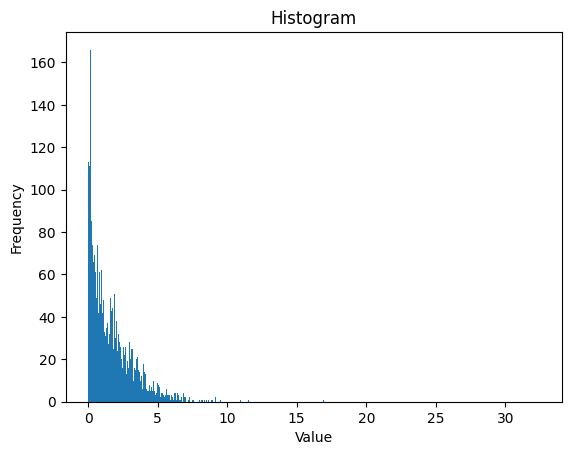

In [84]:
df['reviews_per_month'].plot(kind='hist', bins=1000, title='Histogram')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Upon analyzing the histogram, we can see that the distribution of reviews_per_month is right-skewed. This means that the majority of the data is concentrated on the left side. To handle this, I will use the median to fill the missing values.

In [85]:
median_reviews_per_month = df['reviews_per_month'].median()
print(median_reviews_per_month)

1.23


In [86]:
df['reviews_per_month'] = df['reviews_per_month'].fillna(median_reviews_per_month)

I filled the missing values in reviews_per_month with the median value. Now, let's check the missing values again.

In [87]:
df.isnull().sum()

neighbourhood                     0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimum_nights                    0
number_of_reviews                 0
reviews_per_month                 0
calculated_host_listings_count    0
availability_365                  0
dtype: int64

Now, there are no missing values in the dataset now.

Its time to check for outliers in the dataset. Outliers can significantly impact the performance of our model. I will use the Z-score method to detect and remove outliers. We will visualize the boxplots to visualize the outliers.

In [88]:
import seaborn as sns

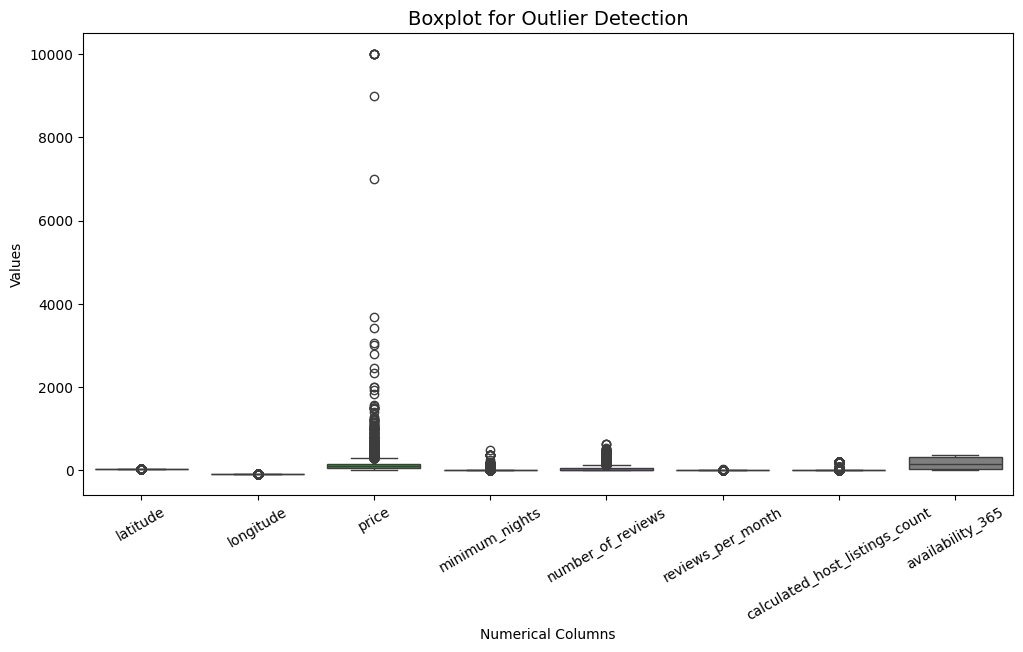

In [89]:
num_cols = df.select_dtypes(include=['number']).columns


# Setting figure size
plt.figure(figsize=(12, 6))

# Creating boxplots for all numerical columns in a single frame
sns.boxplot(data=df[num_cols])


plt.title("Boxplot for Outlier Detection", fontsize=14)
plt.xticks(rotation=30)
plt.xlabel("Numerical Columns")
plt.ylabel("Values")


plt.show()

There are outliers in the dataset. I will remove these outliers using the Z-score method. Z-score is a way to standardize a dataset where the distribution shape might differ from a normal distribution. It calculates the number of standard deviations a data point is from the mean. With this method, we identify outliers that are more than 3 standard deviations away from the mean.

In [90]:
from scipy import stats

# Calculate Z-scores for numeric columns
z_scores = stats.zscore(df.select_dtypes(include=['float64', 'int64']))

# Find outliers where Z-score is above 3 or below -3
outliers_z = (z_scores > 3) | (z_scores < -3)

# Display rows where outliers are detected
outlier_rows_z = df[(outliers_z).any(axis=1)]
outlier_count = outlier_rows_z.shape[0]
print(f"Number of rows with outliers: {outlier_count}")

Number of rows with outliers: 564


We have detected 564 outliers in the dataset. I will remove these outliers.

In [91]:
df.drop(outlier_rows_z.index, inplace=True)


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733 entries, 0 to 6296
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   5733 non-null   object 
 1   latitude                        5733 non-null   float64
 2   longitude                       5733 non-null   float64
 3   room_type                       5733 non-null   object 
 4   price                           5733 non-null   int64  
 5   minimum_nights                  5733 non-null   int64  
 6   number_of_reviews               5733 non-null   int64  
 7   reviews_per_month               5733 non-null   float64
 8   calculated_host_listings_count  5733 non-null   int64  
 9   availability_365                5733 non-null   int64  
dtypes: float64(3), int64(5), object(2)
memory usage: 492.7+ KB


Now, we have cleaned the dataset and removed outliers. The cleaned dataset has 5733 rows and 10 columns. There are two columns with object data type: neighbourhood and room_type. I will encode these columns so, that these columns are converted to numerical data type. This will help us model the data effectively. And will be really helpful to train our model.

In [93]:
df['neighbourhood'].unique()

array(['Hyde Park', 'Lincoln Park', 'Near North Side', 'Logan Square',
       'West Town', 'Uptown', 'North Center', 'Lake View', 'Irving Park',
       'Portage Park', 'West Ridge', 'Near West Side', 'Edgewater',
       'Bridgeport', 'Woodlawn', 'Albany Park', 'Kenwood',
       'Near South Side', 'Avondale', 'Rogers Park', 'Grand Boulevard',
       'Forest Glen', 'Lincoln Square', 'Loop', 'East Garfield Park',
       'North Lawndale', 'Oakland', 'Lower West Side', 'Chatham',
       'Norwood Park', 'Washington Park', 'South Shore', 'Armour Square',
       'South Lawndale', 'Hermosa', 'Mckinley Park', 'Humboldt Park',
       'Douglas', 'North Park', 'Jefferson Park', 'Dunning',
       'West Elsdon', 'Austin', 'Ashburn', 'Belmont Cragin',
       'Greater Grand Crossing', 'Garfield Ridge', 'Brighton Park',
       'Englewood', 'Archer Heights', 'South Chicago', 'Avalon Park',
       'Chicago Lawn', 'Gage Park', 'West Lawn', 'Montclare',
       'West Garfield Park', 'Clearing', 'Roseland', '

First I will be labeling the 'neighbourhood' column. I will analyze the 'neighbouhood' column.

In [94]:
df['neighbourhood'].value_counts()

neighbourhood
West Town          676
Near North Side    565
Lake View          487
Logan Square       366
Lincoln Park       296
                  ... 
West Elsdon          2
West Englewood       2
Burnside             2
Roseland             1
Montclare            1
Name: count, Length: 66, dtype: int64

I have detected that there are multiple neighbourhoods with the same name. It will be better if I find the mean price for each neighbourhood and replace the neighbourhood names with their mean prices. This is known as mean encoding.

In [95]:
# Computing mean encoding for the 'neighbourhood' column based on 'price'
neighbourhood_mapping = df.groupby('neighbourhood')['price'].mean().to_dict()
neighbourhood_mapping

{'Albany Park': 87.9375,
 'Archer Heights': 92.2,
 'Armour Square': 130.765625,
 'Ashburn': 71.3076923076923,
 'Auburn Gresham': 125.16666666666667,
 'Austin': 100.26086956521739,
 'Avalon Park': 102.25,
 'Avondale': 115.79136690647482,
 'Belmont Cragin': 87.0,
 'Bridgeport': 114.3644859813084,
 'Brighton Park': 98.52,
 'Burnside': 132.5,
 'Calumet Heights': 52.85,
 'Chatham': 72.64285714285714,
 'Chicago Lawn': 51.25,
 'Clearing': 71.66666666666667,
 'Douglas': 140.4561403508772,
 'Dunning': 51.625,
 'East Garfield Park': 80.73493975903614,
 'Edgewater': 111.26993865030674,
 'Englewood': 90.26666666666667,
 'Forest Glen': 78.83333333333333,
 'Fuller Park': 87.33333333333333,
 'Gage Park': 64.8,
 'Garfield Ridge': 102.2,
 'Grand Boulevard': 117.0673076923077,
 'Greater Grand Crossing': 85.82142857142857,
 'Hermosa': 69.55555555555556,
 'Humboldt Park': 84.26229508196721,
 'Hyde Park': 90.25842696629213,
 'Irving Park': 95.12080536912751,
 'Jefferson Park': 99.72093023255815,
 'Kenwood'

In [96]:
# Mapping the mean values to the 'neighbourhood' column
df['neighbourhood'] = df['neighbourhood'].map(neighbourhood_mapping)

I have replaced the neighbourhood names with their mean prices. And the column data type of 'neighbourhood' column is now numerical.

In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733 entries, 0 to 6296
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   5733 non-null   float64
 1   latitude                        5733 non-null   float64
 2   longitude                       5733 non-null   float64
 3   room_type                       5733 non-null   object 
 4   price                           5733 non-null   int64  
 5   minimum_nights                  5733 non-null   int64  
 6   number_of_reviews               5733 non-null   int64  
 7   reviews_per_month               5733 non-null   float64
 8   calculated_host_listings_count  5733 non-null   int64  
 9   availability_365                5733 non-null   int64  
dtypes: float64(4), int64(5), object(1)
memory usage: 492.7+ KB


In [98]:
df.head(20)

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,90.258427,41.78790,-87.58780,Private room,60,2,178,2.56,1,353
3,177.445946,41.91769,-87.63788,Entire home/apt,65,4,49,0.63,9,300
4,90.258427,41.79612,-87.59261,Private room,21,1,44,0.61,5,168
5,177.445946,41.91183,-87.64000,Entire home/apt,115,4,19,0.24,9,325
6,197.077876,41.90452,-87.63320,Entire home/apt,99,5,9,0.13,1,316
7,177.445946,41.92335,-87.64951,Private room,289,2,4,0.06,1,179
9,177.445946,41.92679,-87.65521,Entire home/apt,112,32,37,0.29,4,180
10,177.445946,41.92693,-87.65753,Entire home/apt,75,32,47,0.38,4,62
11,138.114754,41.92083,-87.68010,Entire home/apt,94,2,60,0.50,1,332
14,177.445946,41.92673,-87.65731,Entire home/apt,95,32,52,0.47,4,206


In [99]:
neighbourhood_mean = df['neighbourhood'].mean()
neighbourhood_mean

137.28048142333856

Now, Its time to encode the 'room_type' column. I will analyze the 'room_type' column.

In [100]:
df['room_type'].unique()

array(['Private room', 'Entire home/apt', 'Shared room', 'Hotel room'],
      dtype=object)

There are 4 unique room types: Shared room, Private room, Hotel room, and Entire home/apt. I will label encode these room types. It will be easier for me and is effective as well for our model.

In [101]:
room_type_mapping = {
    'Shared room': 0,
    'Private room': 1,
    'Hotel room': 2,
    'Entire home/apt': 3
}
df['room_type'] = df['room_type'].map(room_type_mapping)
df['room_type'].unique()

array([1, 3, 0, 2], dtype=int64)

Now, the 'room_type' column is encoded. Our dataset contains no object data type now.

In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733 entries, 0 to 6296
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   5733 non-null   float64
 1   latitude                        5733 non-null   float64
 2   longitude                       5733 non-null   float64
 3   room_type                       5733 non-null   int64  
 4   price                           5733 non-null   int64  
 5   minimum_nights                  5733 non-null   int64  
 6   number_of_reviews               5733 non-null   int64  
 7   reviews_per_month               5733 non-null   float64
 8   calculated_host_listings_count  5733 non-null   int64  
 9   availability_365                5733 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 492.7 KB


It will be really helpful later while executing the live data in preprocessing step if we create a reference table to keep track of the transformations done. So, I will create a reference table to keep track of the transformations done. For the column 'id', 'name', 'neighbourhood_group', 'last_review', 'host_name', 'host_id' I will use the 'drop' action. For the column 'neighbourhood' I will use the'median_replace' action. For the column 'room_type' I will use the 'label_encoding' action. For mean_encoding action I will save the value of the neighbourhood_mapping and for label_encoding action I will save the value of the room_type_mapping.

In [103]:
ref_table = {
    'field' : ['id', 'name', 'neighbourhood_group','last_review','host_name','host_id','reviews_per_month','neighbourhood','room_type'],
    'action' :['drop','drop','drop','drop','drop','drop','median_replace','mean_encoding','label_encoding'],
    'values' :[np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,1.23,str(neighbourhood_mapping),str(room_type_mapping)]
}

In [104]:
ref_df = pd.DataFrame(ref_table)

I have created a reference table to keep track of the transformations done. And also, conerted into dataframe for better readability and will be used for storing the transformations in a database.

In [105]:
ref_df

,field,action,values
0,id,drop,NaN
1,name,drop,NaN
2,neighbourhood_group,drop,NaN
3,last_review,drop,NaN
4,host_name,drop,NaN
5,host_id,drop,NaN
6,reviews_per_month,median_replace,1.23
7,neighbourhood,mean_encoding,"{'Albany Park': 87.9375, 'Archer Heights': 92...."
8,room_type,label_encoding,"{'Shared room': 0, 'Private room': 1, 'Hotel r..."


In [106]:
schema = r'cleaned'
table = r'ref_table'

I have created a SQL table named'ref_table' in the 'cleaned' schema. The table contains the fields, actions, and values used for the transformations.

In [107]:
ref_df.to_sql(table, con=engine, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

9

![ref_table.png](ref_table.png)

# Part 5 –Feature Engineering and Final Prep

In this part, I will generate new features and adjust existing ones to better capture the underlying patterns in the data. I will prepare my final data for the training of the machine learning model.

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733 entries, 0 to 6296
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   5733 non-null   float64
 1   latitude                        5733 non-null   float64
 2   longitude                       5733 non-null   float64
 3   room_type                       5733 non-null   int64  
 4   price                           5733 non-null   int64  
 5   minimum_nights                  5733 non-null   int64  
 6   number_of_reviews               5733 non-null   int64  
 7   reviews_per_month               5733 non-null   float64
 8   calculated_host_listings_count  5733 non-null   int64  
 9   availability_365                5733 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 492.7 KB


After analyzing the data, I have identified the following new features: "adjusted_price_per_night", "annual_revenue_estimate" and "occupancy_rate".

More reviews often indicate higher demand, but extremely high review counts may signal lower pricing strategies. Adjusting for reviews can better reflect the true market price.
For the "adjusted_price_per_night" feature, I have adjusted the price by dividing it by the natural logarithm of the number of reviews plus 1. This feature captures the impact of reviews on price, while also accounting for the logarithmic nature of review counts.

In [109]:
df["adjusted_price_per_night"] = df["price"] / (1 + np.log1p(df["number_of_reviews"]))


For the "annual_revenue_estimate" feature, I have calculated the annual revenue estimate by multiplying the price by the minimum number of available days, which is 365. This estimates the maximum possible revenue assuming full occupancy for available days.

In [110]:
df["annual_revenue_estimate"] = df["price"] * np.minimum(df["availability_365"], 365)


For the "occupancy_rate" feature, I have calculated the occupancy rate by multiplying the number of reviews per month by 12 and dividing it by the minimum number of nights. This helps estimate the likelihood of occupancy based on reviews.Higher reviews per month generally indicate a higher booking rate, and this helps estimate occupancy levels for better pricing strategies.

In [111]:
df["occupancy_rate"] = (df["reviews_per_month"] * 12) / df["minimum_nights"]
df["occupancy_rate"] = df["occupancy_rate"].clip(upper=1)  # Ensuring it doesn't exceed 100%

In [112]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5733 entries, 0 to 6296
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   neighbourhood                   5733 non-null   float64
 1   latitude                        5733 non-null   float64
 2   longitude                       5733 non-null   float64
 3   room_type                       5733 non-null   int64  
 4   price                           5733 non-null   int64  
 5   minimum_nights                  5733 non-null   int64  
 6   number_of_reviews               5733 non-null   int64  
 7   reviews_per_month               5733 non-null   float64
 8   calculated_host_listings_count  5733 non-null   int64  
 9   availability_365                5733 non-null   int64  
 10  adjusted_price_per_night        5733 non-null   float64
 11  annual_revenue_estimate         5733 non-null   int64  
 12  occupancy_rate                  5733 no

Now there are 13 columns in the cleaned dataset. This dataset now only contains numeric data types.

In [113]:
df.head(10)

,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,adjusted_price_per_night,annual_revenue_estimate,occupancy_rate
0,90.258427,41.78790,-87.58780,1,60,2,178,2.56,1,353,9.697149,21180,1.00000
3,177.445946,41.91769,-87.63788,3,65,4,49,0.63,9,300,13.232837,19500,1.00000
4,90.258427,41.79612,-87.59261,1,21,1,44,0.61,5,168,4.368936,3528,1.00000
5,177.445946,41.91183,-87.64000,3,115,4,19,0.24,9,325,28.780707,37375,0.72000
6,197.077876,41.90452,-87.63320,3,99,5,9,0.13,1,316,29.976518,31284,0.31200
7,177.445946,41.92335,-87.64951,1,289,2,4,0.06,1,179,110.751821,51731,0.36000
9,177.445946,41.92679,-87.65521,3,112,32,37,0.29,4,180,24.150495,20160,0.10875
10,177.445946,41.92693,-87.65753,3,75,32,47,0.38,4,62,15.396614,4650,0.14250
11,138.114754,41.92083,-87.68010,3,94,2,60,0.50,1,332,18.392158,31208,1.00000
14,177.445946,41.92673,-87.65731,3,95,32,52,0.47,4,206,19.113565,19570,0.17625


In [114]:
schema = r'cleaned'
table = r'chicago_airbnb_cleaned'

I will create a SQL table named 'chicago_airbnb_cleaned' in the 'cleaned' schema. The table contains the cleaned and engineered data.

In [115]:
df.to_sql(table, con=engine, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

5733

Screenshot of cleaned data with new features generated with feature engineering

![cleaned_data.png](cleaned_data.png)


## Analyzing Feature Importance

In this part, I will analyze the feature importance of the dataset to understand which features are most important in predicting the price of an Airbnb listing in Chicago. I will use permutation importance to measure the importance of each feature in predicting the price. I will use the Random Forest Regressor as an example model because this is the model I will use for my project goal.

In [116]:
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [118]:
perm_importance = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')


feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)


print(feature_importance_df)





                           Feature    Importance
9         adjusted_price_per_night  44017.587572
5                number_of_reviews  16978.610269
10         annual_revenue_estimate  11325.411066
8                 availability_365   3069.956778
6                reviews_per_month     51.558683
7   calculated_host_listings_count      2.313990
3                        room_type      0.976771
2                        longitude      0.489476
0                    neighbourhood     -0.412978
1                         latitude     -0.926037
11                  occupancy_rate     -1.200049
4                   minimum_nights     -2.663213


The engineered features like "adjusted_price_per_night", "annual_revenue_estimate" have quite high importance in predicting the price of an Airbnb listing in Chicago. These features can be used as predictors in future pricing strategies. Occupancy_rate has a relatively low importance, indicating that it may not be a strong predictor of price.

Text(0, 0.5, 'Feature Name')

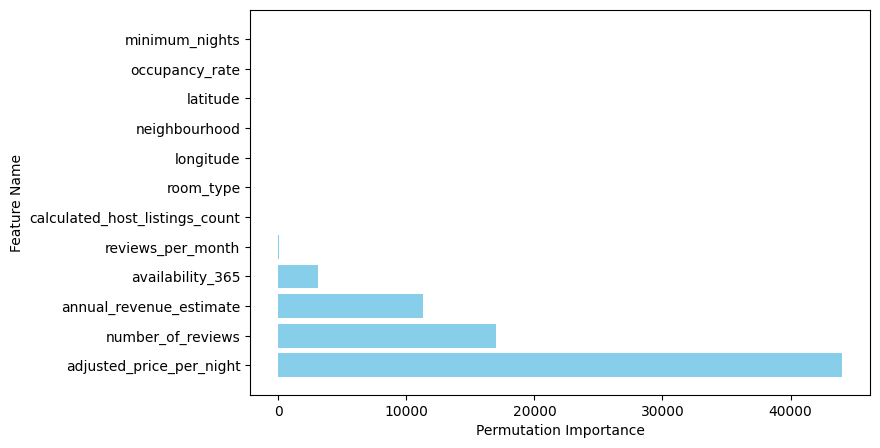

In [119]:
plt.figure(figsize=(8, 5))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature Name')

# Part 6 – Constructing an Optimal Model

In this part, I will construct an optimal model for predicting the price of an Airbnb listing in Chicago. I will use the Random Forest Regressor as my machine learning model. I have chosen this model because it is widely used for regression tasks and has a good performance on various datasets. My goal is to predict the price of an Airbnb listing in Chicago based on the given features so that I can set the correct price for future listings based on the features of the listings. Random Forest Regressor is a powerful model that can handle both linear and non-linear relationships between features and the target variable. It works well with numerical dataset. So, choosing Random Forest Regressor is a good choice for this project.

I will generate a feature set and target variable.

In [120]:
X = df.drop(columns=["price","occupancy_rate"])  # Features
y = df["price"]  # Target variable

I will split the dataset into training, validation, and testing sets. I will use validation set to optimize the hyperparameters of the model and select the best model iteratively.

In [121]:
temp_X, test_X, temp_y, test_y = train_test_split(X, y, test_size=0.2, random_state=42)
train_X, val_X, train_y, val_y = train_test_split(temp_X, temp_y, test_size=0.25, random_state=42)

First I will train a baseline model using the training set and evaluate its performance on the dataset.

In [122]:
#Baseline Model
baseline_model = RandomForestRegressor(random_state=42)
baseline_model.fit(train_X, train_y)
preds = baseline_model.predict(val_X)

In [123]:
print("Baseline Model Performance:")
print("R2 Score:", r2_score(val_y, preds))
print("RMSE:", np.sqrt(mean_squared_error(val_y, preds)))
print("MAE:", mean_absolute_error(val_y, preds))


Baseline Model Performance:
R2 Score: 0.9617112514377937
RMSE: 28.74958126528769
MAE: 5.6058849171752385


I found that the baseline model has a relatively high R2 score (0.96) and RMSE score of (28.74) and MAE score of (5.6). I will now perform iterative hyperparameter tuning to find the optimal hyperparameters for the Random Forest Regressor model.

I have set the parameter grid to search over different combinations of n_estimators (number of trees) and max_depth (maximum depth of the trees). The values I have chosen for n_estimators are 100,200 and for max_depth are 10, 20. I will run the for loop to find the best combination of hyperparameters. I have used validation set to evaluate the performance of each combination of hyperparameters. And I will generate the best combination of hyperparameters which gives the best performance on the validation set.

In [124]:
#Iterative Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20]
}

best_score = float("inf")
best_params = {}

for n in param_grid['n_estimators']:
    for depth in param_grid['max_depth']:
        
        model = RandomForestRegressor(n_estimators=n, max_depth=depth,random_state=42)
        model.fit(train_X, train_y)
        val_preds = model.predict(val_X)
        score = mean_squared_error(val_y, val_preds)
        
        if score < best_score:
            best_score = score
            best_params = {'n_estimators': n, 'max_depth': depth}

print("Best Parameters:", best_params)

Best Parameters: {'n_estimators': 200, 'max_depth': 10}


After iterative hyperparameter tuning, I found that the best combination of hyperparameters for the Random Forest Regressor model is n_estimators=200 and max_depth=10. I will be using this combination of hyperparameters to train the final model and evaluate its performance on the testing set.

In [125]:
final_model = RandomForestRegressor(**best_params, random_state=42)
final_model.fit(pd.concat([train_X, val_X]), pd.concat([train_y, val_y]))


test_preds = final_model.predict(test_X)
print("Final Model Test Performance:")
print("R2 Score:", r2_score(test_y, test_preds))
print("RMSE:", np.sqrt(mean_squared_error(test_y, test_preds)))
print("MAE:", mean_absolute_error(test_y, test_preds))



Final Model Test Performance:
R2 Score: 0.9777287783211825
RMSE: 19.78453799915218
MAE: 3.384411818963142


Comapring the performance of the baseline model with the final model, I found that the final model has a higher R2 score (0.97) and RMSE score of 19 which is lower than the baseline model's RMSE score of 28.74. The final model also has a lower MAE score of 3.38 which is lower than the baseline model's MAE score of 5.6. This indicates that the final model is performing better on the testing set compared to the baseline model. I will save the final model as a joblib file named 'random_forest_regressor.joblib'. This file can be used to make predictions on new data using the trained model.

In [126]:
import joblib

In [127]:
joblib.dump(final_model, 'random_forest_regressor.joblib')

['random_forest_regressor.joblib']